# Assignment 1 - Computational Psycholinguistics
By Daan Brugmans

This assignment concerns an investigation into the semantic priming effect.
The semantic priming effect is, for the purposes of this assignment, a psycholinguistic phenomenon that occurs when processing text.
Specifically, if a word (called the *target*) is preceded by a semantically similar/related word (called the *prime*), then the person processing the text may be able to process the target word quicker than in cases where the prime word is semantically unrelated.
In this assignment, I attempt to model this effect computationally, by training various word2vec models on available training data, calculating the cosine similarities between the semantic embeddings of targets and primes of a test set, and analyzing the results.

## 1. Imports and Seed
I use the Gensim library for training and using word2vec models.

In [1]:
import os
import itertools

import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from gensim.models import Word2Vec
from tqdm import tqdm

SEED = 3131

## 2. Data Loading
For this assignment, two fully prepared test sets of primes, targets, and reaction times were handed to us, of which students should use one.
I use the "data naming" test set, a experiment dataset in which participants had to pronounce the target on-screen as fast as possible, when preceded by a prime.
The reaction times of the participants for prime-target pairs, alongside the categorical semantic relatedness of the pair (strong, weak, unrelated (strong & weak)) are recorded in the test set.

I apply some additional data preprocessing.
First, I set semantic relatedness to the same class `unrel`, as opposed to having different classes for unrelated prime-target pairs that have either low or high semantic similarity.
I made this choice because we want to analyze all unrelated prime-target pairs as a single, cohesive unit.

I also calculate the semantic priming effect by hand.
I do this by comparing the difference between the mean reaction times of a specific target word for primes that are semantically related versus primes that are semantically unrelated.
I have made two design decisions here:
1. I take the median of the related and unrelated mean reaction times, as opposed to calculating the mean or something else.
This is because the final mean of the mean reaction times given per semantic relatedness category was quite sensitive to outliers, and I expected the median to be more representative of the data.
2. I set all negative semantic priming effects to 0.
This is because I calculate the difference by subtracting the median reaction time for related primes from the median reaction time for unrelated primes.
If this value is negative, then that would imply that reaction times are actually faster when primes are unrelated.
In this case, no semantic priming effect would be taking place, so I set it to 0.

Finally, I draw 2 plots: both of the distribution of the semantic priming effect, with the first plot having negative priming effects, and the second plot setting all negative priming effects to zero.
Although I only use the latter distribution in my analyses, the former distribution shows that, if unnormalized, the calculated semantic priming effects are normally distributed, centering around 0.
This would imply that more noticeable instances of the semantic priming effect occur less often than unnoticeable ones.

,isi,prime,target,condition,meanRT,median_priming_effect
0,50,capability,ability,strong,580.5,41.8
1,1050,capability,ability,strong,577.4,41.8
2,50,means,ability,weak,538.0,41.8
3,1050,means,ability,weak,571.0,41.8
4,50,fuel,ability,unrel,639.3,41.8
...,...,...,...,...,...,...
11035,1050,giraffe,zoo,weak,545.4,0.0
11036,50,crisp,zoo,unrel,542.8,0.0
11037,1050,crisp,zoo,unrel,685.2,0.0
11038,50,bottle,zoo,unrel,545.6,0.0


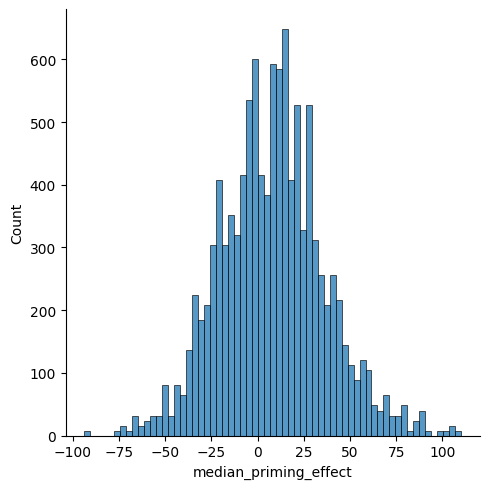

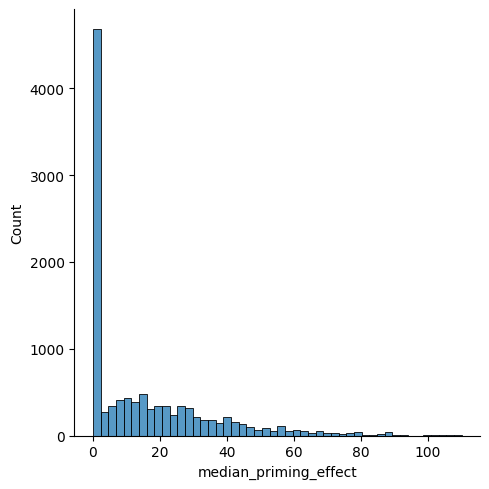

In [2]:
PATH_TO_EXPERIMENT_DATA = os.path.join(os.getcwd(), "data", "data_naming.csv")
PATH_TO_TRAIN_DATA = os.path.join(os.getcwd(), "data", "train_en.txt")
MODEL_DIR = os.path.join(os.getcwd(), "models")

def calculate_median_priming_effect(df: pd.DataFrame) -> None:
    df["median_priming_effect"] = 0.0
    grouped_df = df.groupby("target")
    
    # Iterate over the target words and calculate their priming effect.
    # This is done by comparing the difference in median reaction time between targets with a related prime and targets with an unrelated prime.
    for _, group in grouped_df:
        median_of_mean_rt_related = group[group["condition"] != "unrel"]["meanRT"].median()
        median_of_mean_rt_unrelated = group[group["condition"] == "unrel"]["meanRT"].median()
        
        priming_effect = median_of_mean_rt_unrelated - median_of_mean_rt_related
        
        df.loc[group.index, "median_priming_effect"] = priming_effect

test_df = pd.read_csv(PATH_TO_EXPERIMENT_DATA)
test_df = test_df.replace("unrel_strong", "unrel")
test_df = test_df.replace("unrel_weak", "unrel")

calculate_median_priming_effect(test_df)
# Draw distribution of the median priming effects without normalizing negative priming effects to zero. Note that the distribution is Gaussian.
sns.displot(data=test_df, x="median_priming_effect")

# Set negative priming effects to 0, since if a priming effect is negative, it doesn't exist.
test_df["median_priming_effect"] = test_df["median_priming_effect"].apply(lambda x: 0 if x <= 0 else x)
# Draw distribution of the median priming effects after normalizing negative priming effects to zero.
sns.displot(data=test_df, x="median_priming_effect")

display(test_df)

## 3. Model Training
If you want to run this notebook, you do not need to train the models, since the pre-trained models will be loaded later.

As part of the assignment, students should train multiple word2vec models, and use them in their analyses.
Specifically, students should pick two of three hyperparameters, those being model architecture, semantic embedding size, and word window size, and try out multiple values.
I have chosen to try out various values of the architecture (`sg`), that is, Continuous Bag-Of-Word (CBOW) models versus SkipGram models, and three different word window sizes (`window`): 2 (small), 5 (default), and 8 (large).
I set the semantic embedding size (`vector_size`) to 300 dimensions, and train for 5 epochs.
I have saved the models on disk and they can be found in the `models` folder.

In [ ]:
WORD2VEC_VECTOR_SIZE = 300
WORD2VEC_MIN_COUNT = 5
WORD2VEC_EPOCHS = 5
WORD2VEC_WORKERS = 2

WORD2VEC_SG_SPACE = {0, 1}
WORD2VEC_WINDOW_SPACE = {2, 5, 8}
# Calculate Cartesian product of the search spaces to get all possible combinations of hyperparameters.
WORD2VEC_SEARCH_SPACE = itertools.product(WORD2VEC_SG_SPACE, WORD2VEC_WINDOW_SPACE)

for architecture, window_size in tqdm(WORD2VEC_SEARCH_SPACE):
    if architecture == 0:
        architecture_name = "cbow"
    elif architecture == 1:
        architecture_name = "skipgram"
    else:
        raise ValueError("Invalid value of sg encountered:", architecture, ", was of type", type(architecture))
    
    word2vec_model = Word2Vec(
        corpus_file=PATH_TO_TRAIN_DATA,
        sg=architecture,
        window=window_size,
        vector_size=WORD2VEC_VECTOR_SIZE,
        min_count=WORD2VEC_MIN_COUNT,
        epochs=WORD2VEC_EPOCHS,
        seed=SEED,
        workers=WORD2VEC_WORKERS
    )
    
    path_to_word2vec_model = os.path.join(MODEL_DIR, f"{architecture_name}_window_{window_size}.word2vec")
    word2vec_model.save(path_to_word2vec_model)

## 4. Model Loading

In [3]:
cbow_window_2 = Word2Vec.load(os.path.join(MODEL_DIR, "cbow_window_2.word2vec"))
cbow_window_5 = Word2Vec.load(os.path.join(MODEL_DIR, "cbow_window_5.word2vec"))
cbow_window_8 = Word2Vec.load(os.path.join(MODEL_DIR, "cbow_window_8.word2vec"))

skipgram_window_2 = Word2Vec.load(os.path.join(MODEL_DIR, "skipgram_window_2.word2vec"))
skipgram_window_5 = Word2Vec.load(os.path.join(MODEL_DIR, "skipgram_window_5.word2vec"))
skipgram_window_8 = Word2Vec.load(os.path.join(MODEL_DIR, "skipgram_window_8.word2vec"))

## 5. Model Analyses
I perform two analyses:
1. I compute the mean cosine similarity between prime-target pairs for all three semantic relatedness levels (strong, weak, unrelated), and compare their values to the semantic relatedness level.
We expect to see that the mean cosine similarity should be higher in prime-target pairs that are semantically related than those that are not, since the cosine similarity between semantic embeddings is a measure of how closely related the semantics of two words are.
2. I analyze the predictive power of the cosine similarity between prime-target pairs for the sizes of the priming effects.
I do this by plotting the cosine similarities between prime-target pairs against the median priming effects I calculated.
I also calculate a linear regression model of this relationship to quantitatively express that predictive power.

I perform these analyses using all six models.
For the implementation of these analysis, I have constructed a handful of functions that encapsulate the analyses' steps:
- `calculate_cosine_similarities`: calculates the cosine similarities of all prime-target pairs in the dataframe provided using the provided word2vec model.
If the prime or target does not exist in the model's vocabulary, and thus cannot be modeled in the model's space, the cosine similarity is set to 0.
- `print_mean_cosine_similarity_by_semantic_relatedness`: calculates, then prints the mean cosine similarity for the three semantic relatedness levels (strong, weak, unrelated) using the provided dataframe and the specified cosine similarity column to use.
- `plot_cosine_similarity_as_predictor_of_mean_reaction_time`: paints the scatter plot of the cosine similarity of prime-target pairs against their mean reaction times, for every semantic relatedness level.
It also calculates and paints a linear regression model for every scatter plot.
This function is supplementary and shows how the cosine similarities are distributed among semantic relatedness levels, and how this distribution interacts with the distribution of mean reaction times.
- `plot_cosine_similarity_as_predictor_of_median_priming_effect`: paints the scatter plot of the cosine similarity of prime-target pairs against their median priming effects.
It also calculates and paints a linear regression model for the plot.

For the first analysis, I find that, regardless of model architecture or window size, the mean cosine similarities for the semantic relatedness levels are all very similar: the mean for strong relatedness is always roughly 0.4, the mean for weak relatedness is always roughly 0.3, and the mean for unrelatedness is always roughly 0.07 for CBOW models and 0.11 for SkipGram models.
From my findings, it is quite clear that the semantic relatedness of prime-target pairs is captured by their cosine similarities.
I would conclude that semantic relatedness levels and cosine similarities align.

For the second analysis, I was unable to find any proof that cosine similarities are good predictors of priming effects.
For all of the models and cosine similarities used, there seems to exist no clear relationship between cosine similarity and priming effect size: not only are the regression models clearly incapable of modeling a linear relationship between the variables, from intuition, I am also unable to do so.
The data in the scatter plots seem very varied, and only one big cluster of data.
I would conclude, for the data analyzed and the models used, that, irrespective of model hyperparameter values, cosine similarities are not a good predictor of priming effect size.

In [4]:
def calculate_cosine_similarities(row: pd.Series, word2vec_model: Word2Vec) -> float:
    """Calculates the cosine similarities of all prime-target pairs in the dataframe provided using the provided word2vec model.
    If the prime or target does not exist in the model's vocabulary, and thus cannot be modeled in the model's space, the cosine similarity is set to 0."""
    
    model_vocabulary = list(word2vec_model.wv.index_to_key) # NOTE: Instruction from assignment (model.wv.vocab) does not work in Gensim 4.0.0+
    
    if row["prime"] not in model_vocabulary:
        return 0.0
    
    if row["target"] not in model_vocabulary:
        return 0.0
    
    return word2vec_model.wv.similarity(row["prime"], row["target"])

def print_mean_cosine_similarity_by_semantic_relatedness(df: pd.DataFrame, similarity_column_name: str) -> None:
    """Calculates, then prints the mean cosine similarity for the three semantic relatedness levels (strong, weak, unrelated) using the provided dataframe and the specified cosine similarity column to use."""
    
    strong_mean = df[df["condition"] == "strong"][similarity_column_name].mean()
    weak_mean = df[df["condition"] == "weak"][similarity_column_name].mean()
    unrel_mean = df[df["condition"] == "unrel"][similarity_column_name].mean()
    
    print(f"Mean Cosine Similarities by Semantic Relatedness using {similarity_column_name}:")
    print(f"    Strong: {strong_mean}")
    print(f"    Weak: {weak_mean}")
    print(f"    Unrelated: {unrel_mean}")
    
def plot_cosine_similarity_as_predictor_of_mean_reaction_time(df: pd.DataFrame, similarity_column_name: str, formula_text_offset: float, formula_text_coeff: float) -> None:
    """Paints the scatter plot of the cosine similarity of prime-target pairs against their mean reaction times, for every semantic relatedness level. 
    It also calculates and paints a linear regression model for every scatter plot. 
    This function is supplementary and shows how the cosine similarities are distributed among semantic relatedness levels, and how this distribution interacts with the distribution of mean reaction times.
    
    Args: 
        df: The dataframe containing the information to plot.
        similarity_column_name: The name of the cosine similarity column to plot on the x-axis.
        formula_text_offset: The x-coordinate at which the function of the linear regression should be painted.
        formula_text_coeff: The spacing for the painted linear regression formula between subplots."""
        
    # Draw a linear regression plot, a scatter plot with a linear regression line on top of it
    plot = sns.lmplot(x=similarity_column_name, y="meanRT", col="condition", data=df, seed=SEED, line_kws={"color": "C1"})
    
    # Iterate over the semantic relatedness conditions
    for indices, facet_df in plot.facet_data():
        # Calculate slope, intercept, and correlation coefficient r of the linear regression shown in the plot
        reg_slope, reg_intercept, r, _, _ = scipy.stats.linregress(
            x=facet_df[similarity_column_name],
            y=facet_df["meanRT"]
        )
        
        # Write the regression's formula onto the plot
        plt.text(formula_text_offset + (indices[1] * formula_text_coeff), 1000, f"y = {round(reg_slope, 2)}x + {round(reg_intercept)}")
        plt.text(formula_text_offset + (indices[1] * formula_text_coeff), 975, f"r = {round(r, 3)}")
        
def plot_cosine_similarity_as_predictor_of_median_priming_effect(df: pd.DataFrame, similarity_column_name: str, formula_text_offset: int) -> None:
    """paints the scatter plot of the cosine similarity of prime-target pairs against their median priming effects. 
    It also calculates and paints a linear regression model for the plot.
    
    Args: 
        df: The dataframe containing the information to plot.
        similarity_column_name: The name of the cosine similarity column to plot on the x-axis.
        formula_text_offset: The x-coordinate at which the function of the linear regression should be painted."""
    
    # Remove duplicate rows where prime, target, and similarity are identical, since dupes would clutter the plot
    dropped_dupes_df = df.drop_duplicates(subset=["prime", "target", similarity_column_name], keep="first")
    
    # Draw a linear regression plot, a scatter plot with a linear regression line on top of it
    sns.lmplot(x=similarity_column_name, y="median_priming_effect", data=dropped_dupes_df, seed=SEED, line_kws={"color": "C1"})
    
    # Calculate slope, intercept, and correlation coefficient r of the linear regression shown in the plot
    reg_slope, reg_intercept, r, _, _ = scipy.stats.linregress(
        x=dropped_dupes_df[similarity_column_name],
        y=dropped_dupes_df["median_priming_effect"]
    )
    
    # Write the regression's formula onto the plot
    plt.text(formula_text_offset, 110, f"y = {round(reg_slope, 2)}x + {round(reg_intercept)}")
    plt.text(formula_text_offset, 105, f"r = {round(r, 3)}")
    

### 5.1 CBOW Window 2

Mean Cosine Similarities by Semantic Relatedness using cbow_2_cosine:
    Strong: 0.409881381788696
    Weak: 0.2997494748952137
    Unrelated: 0.07716377347408696


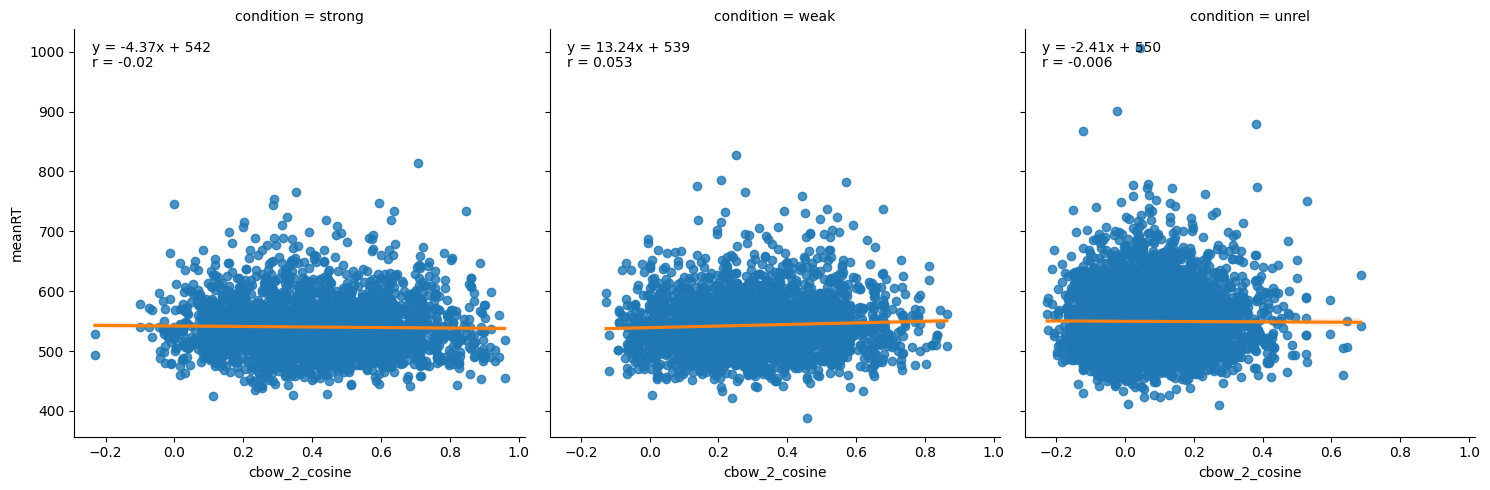

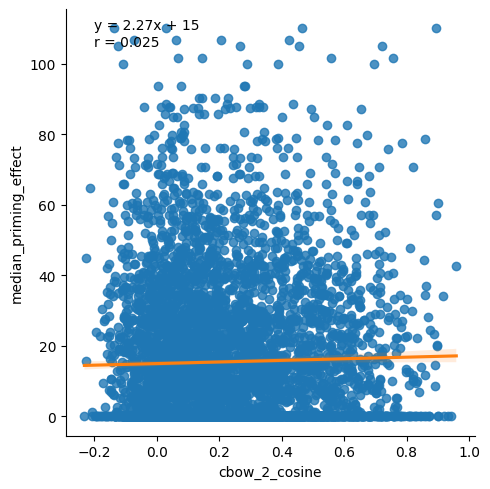

In [5]:
test_df["cbow_2_cosine"] = test_df.apply(calculate_cosine_similarities, word2vec_model=cbow_window_2, axis=1)

print_mean_cosine_similarity_by_semantic_relatedness(test_df, "cbow_2_cosine")

plot_cosine_similarity_as_predictor_of_mean_reaction_time(test_df, "cbow_2_cosine", -3, 1.38)
plot_cosine_similarity_as_predictor_of_median_priming_effect(test_df, "cbow_2_cosine", -0.2)

### 5.2 CBOW Window 5

Mean Cosine Similarities by Semantic Relatedness using cbow_5_cosine:
    Strong: 0.4162317159413563
    Weak: 0.30492301575592345
    Unrelated: 0.06981662859935844


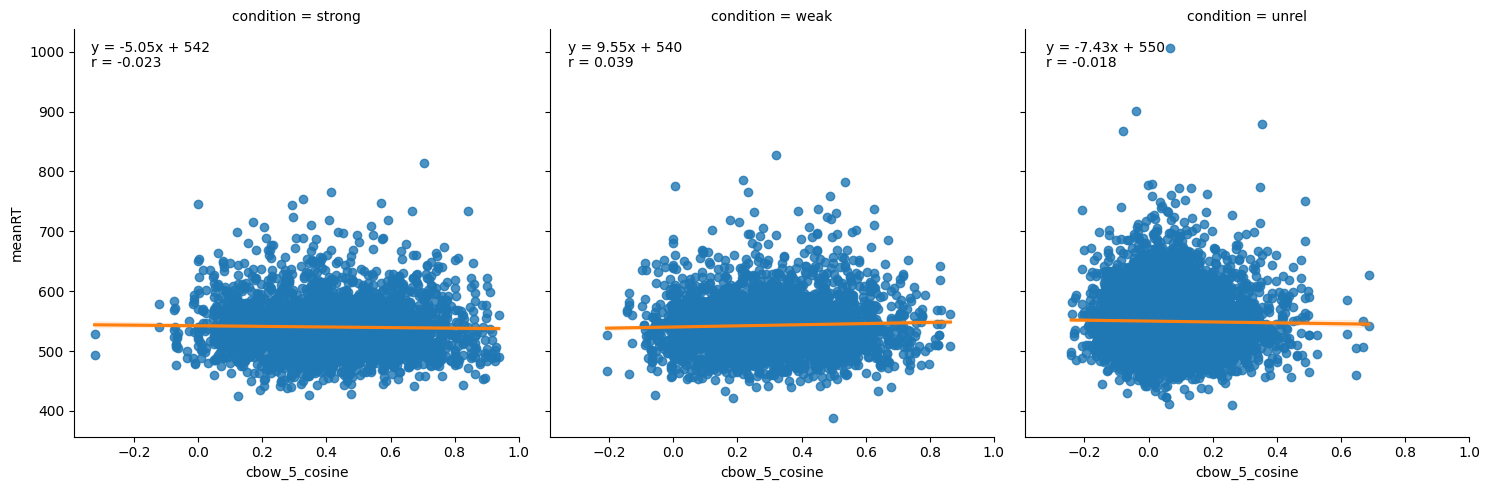

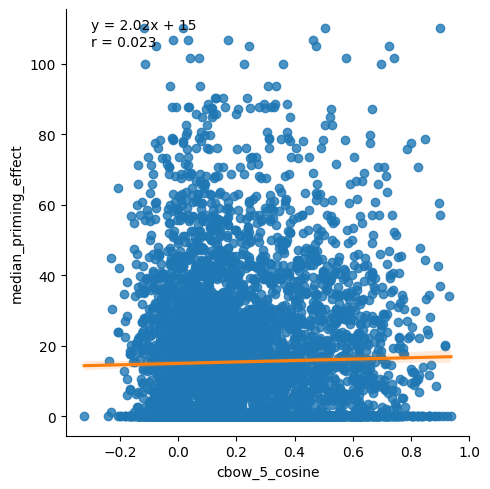

In [6]:
test_df["cbow_5_cosine"] = test_df.apply(calculate_cosine_similarities, word2vec_model=cbow_window_5, axis=1)

print_mean_cosine_similarity_by_semantic_relatedness(test_df, "cbow_5_cosine")

plot_cosine_similarity_as_predictor_of_mean_reaction_time(test_df, "cbow_5_cosine", -3.3, 1.49)
plot_cosine_similarity_as_predictor_of_median_priming_effect(test_df, "cbow_5_cosine", -0.3)

### 5.3 CBOW Window 8

Mean Cosine Similarities by Semantic Relatedness using cbow_8_cosine:
    Strong: 0.41480248304239165
    Weak: 0.3044206501738897
    Unrelated: 0.06484616057024549


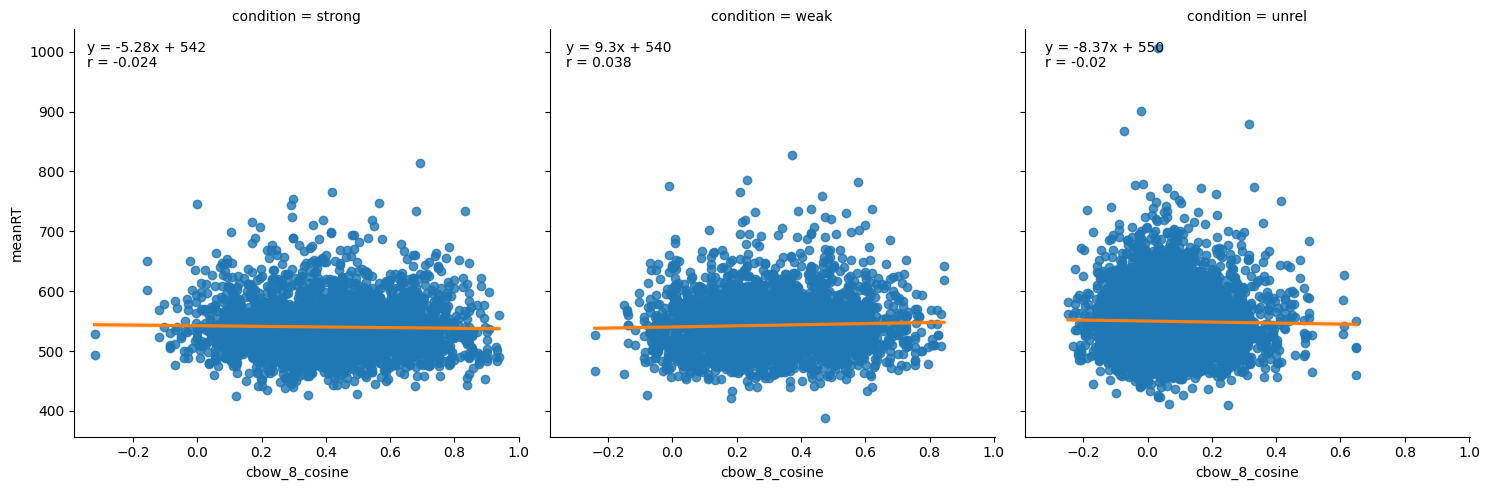

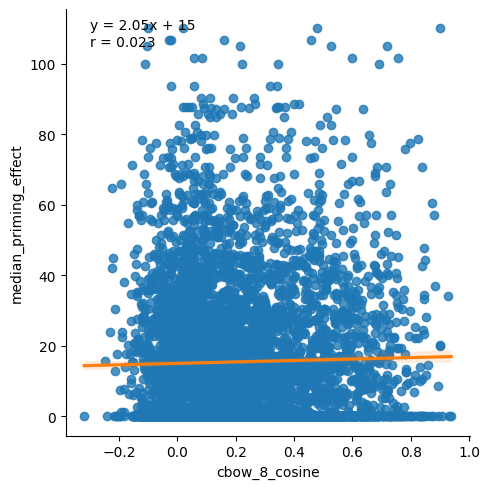

In [7]:
test_df["cbow_8_cosine"] = test_df.apply(calculate_cosine_similarities, word2vec_model=cbow_window_8, axis=1)

print_mean_cosine_similarity_by_semantic_relatedness(test_df, "cbow_8_cosine")

plot_cosine_similarity_as_predictor_of_mean_reaction_time(test_df, "cbow_8_cosine", -3.3, 1.49)
plot_cosine_similarity_as_predictor_of_median_priming_effect(test_df, "cbow_8_cosine", -0.3)

### 5.4 Skip-Gram Window 2

Mean Cosine Similarities by Semantic Relatedness using skipgram_2_cosine:
    Strong: 0.3972847288973002
    Weak: 0.2968085164586386
    Unrelated: 0.11298818337915256


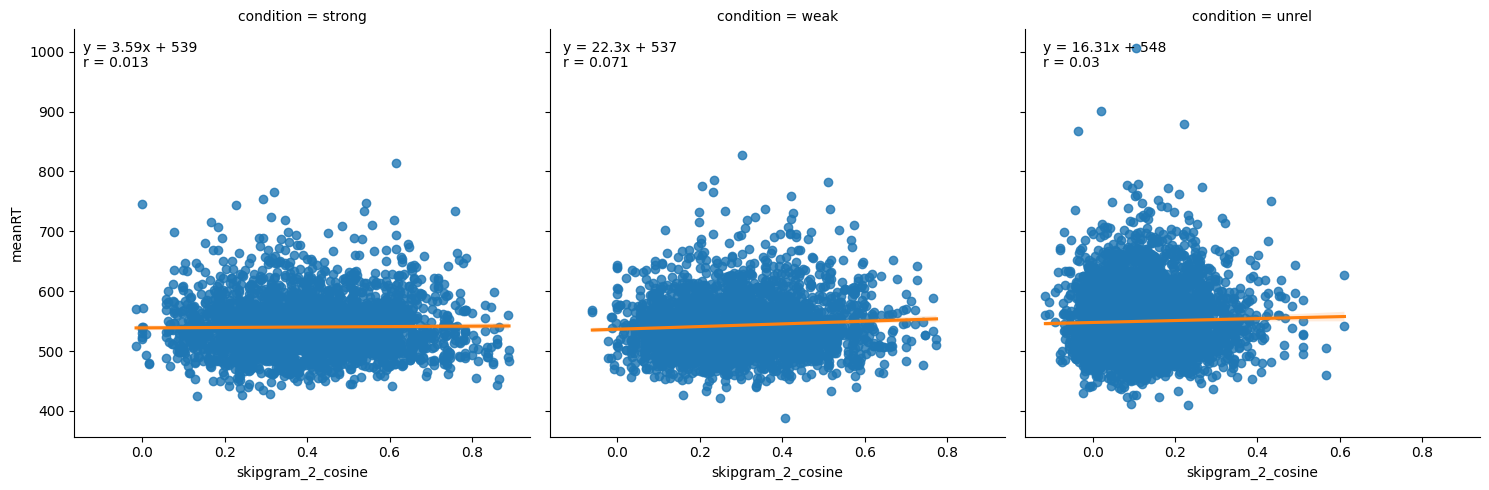

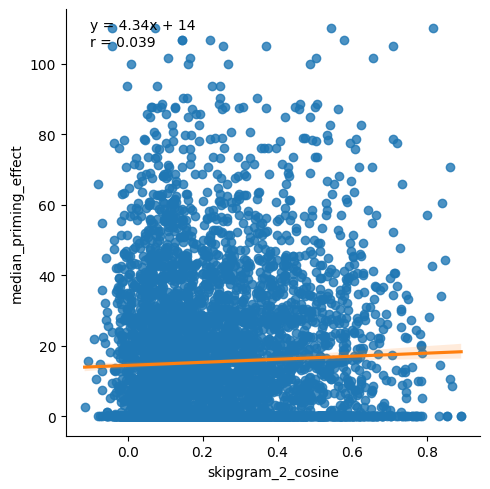

In [8]:
test_df["skipgram_2_cosine"] = test_df.apply(calculate_cosine_similarities, word2vec_model=skipgram_window_2, axis=1)

print_mean_cosine_similarity_by_semantic_relatedness(test_df, "skipgram_2_cosine")

plot_cosine_similarity_as_predictor_of_mean_reaction_time(test_df, "skipgram_2_cosine", -2.45, 1.165)
plot_cosine_similarity_as_predictor_of_median_priming_effect(test_df, "skipgram_2_cosine", -0.1)

### 5.5 Skip-Gram Window 5

Mean Cosine Similarities by Semantic Relatedness using skipgram_5_cosine:
    Strong: 0.40953222510701826
    Weak: 0.3067186014601907
    Unrelated: 0.1050422957540466


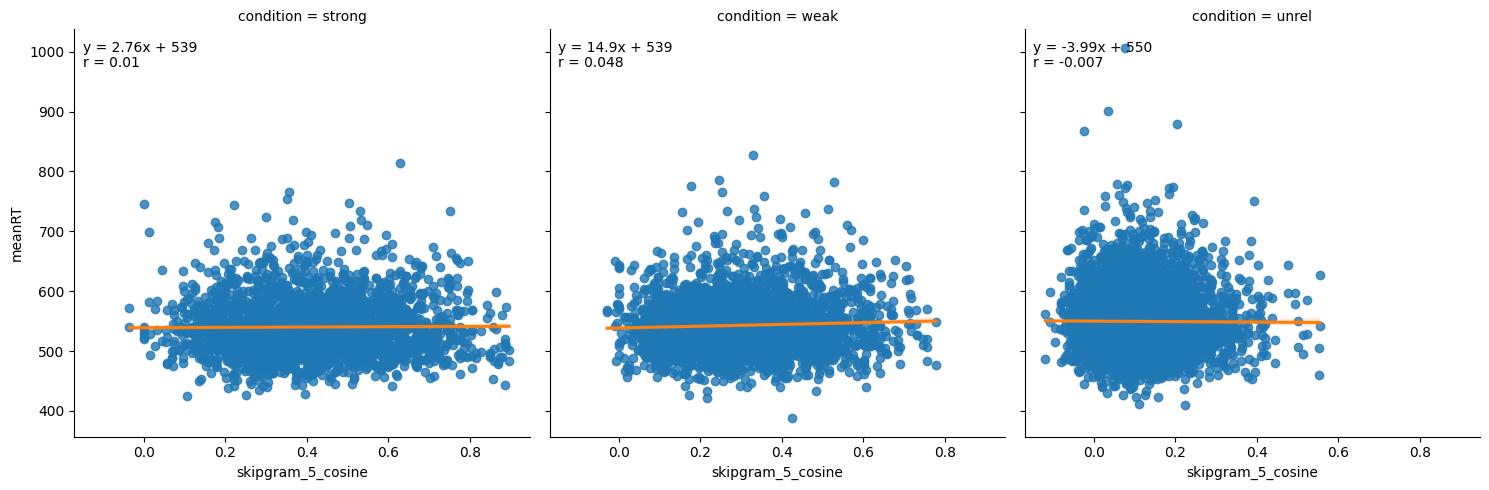

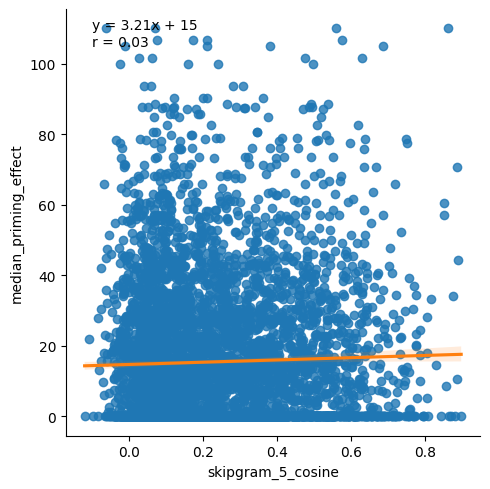

In [9]:
test_df["skipgram_5_cosine"] = test_df.apply(calculate_cosine_similarities, word2vec_model=skipgram_window_5, axis=1)

print_mean_cosine_similarity_by_semantic_relatedness(test_df, "skipgram_5_cosine")

plot_cosine_similarity_as_predictor_of_mean_reaction_time(test_df, "skipgram_5_cosine", -2.48, 1.165)
plot_cosine_similarity_as_predictor_of_median_priming_effect(test_df, "skipgram_5_cosine", -0.1)

### 5.6 Skip-Gram Window 8

Mean Cosine Similarities by Semantic Relatedness using skipgram_8_cosine:
    Strong: 0.4170220403837553
    Weak: 0.31366485754796475
    Unrelated: 0.10707668869690151


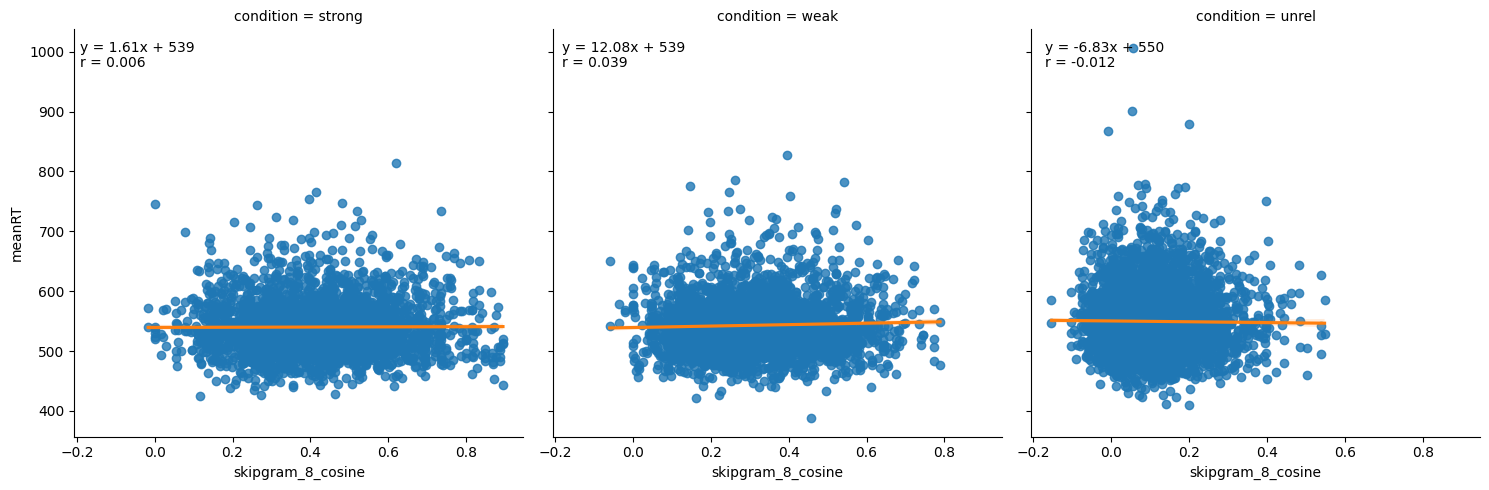

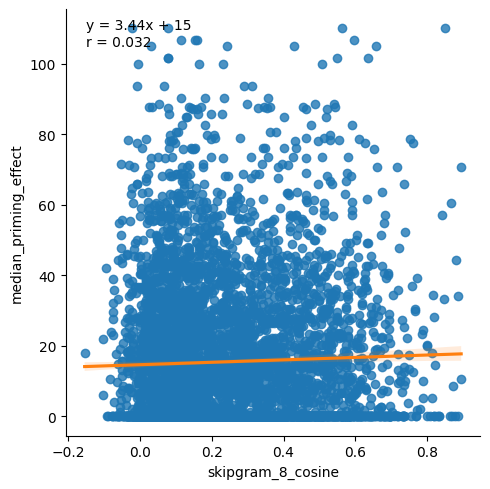

In [11]:
test_df["skipgram_8_cosine"] = test_df.apply(calculate_cosine_similarities, word2vec_model=skipgram_window_8, axis=1)

print_mean_cosine_similarity_by_semantic_relatedness(test_df, "skipgram_8_cosine")

plot_cosine_similarity_as_predictor_of_mean_reaction_time(test_df, "skipgram_8_cosine", -2.65, 1.24)
plot_cosine_similarity_as_predictor_of_median_priming_effect(test_df, "skipgram_8_cosine", -0.15)

## 6. Final Overview of Cosine Similarities

After all cosine similarities are calculated for all word2vec models, I visualize the distributions of the cosine similarities.
We can see that, across models, the distribution of cosine similarities is quite similar: the distribution is Gaussian, centered around 0.1, and is positively skewed.

,isi,prime,target,condition,meanRT,median_priming_effect,cbow_2_cosine,cbow_5_cosine,cbow_8_cosine,skipgram_2_cosine,skipgram_5_cosine,skipgram_8_cosine
0,50,capability,ability,strong,580.5,41.8,0.595391,0.570227,0.565737,0.541743,0.504666,0.480975
1,1050,capability,ability,strong,577.4,41.8,0.595391,0.570227,0.565737,0.541743,0.504666,0.480975
2,50,means,ability,weak,538.0,41.8,0.051197,0.076062,0.092510,0.064069,0.057896,0.100651
3,1050,means,ability,weak,571.0,41.8,0.051197,0.076062,0.092510,0.064069,0.057896,0.100651
4,50,fuel,ability,unrel,639.3,41.8,0.152527,0.129279,0.108780,0.163890,0.128521,0.118592
...,...,...,...,...,...,...,...,...,...,...,...,...
11035,1050,giraffe,zoo,weak,545.4,0.0,0.368324,0.375707,0.351164,0.320095,0.323887,0.363072
11036,50,crisp,zoo,unrel,542.8,0.0,-0.061934,-0.062173,-0.061959,-0.052210,-0.016120,-0.018936
11037,1050,crisp,zoo,unrel,685.2,0.0,-0.061934,-0.062173,-0.061959,-0.052210,-0.016120,-0.018936
11038,50,bottle,zoo,unrel,545.6,0.0,0.189919,0.160162,0.129380,0.109179,0.107860,0.139709


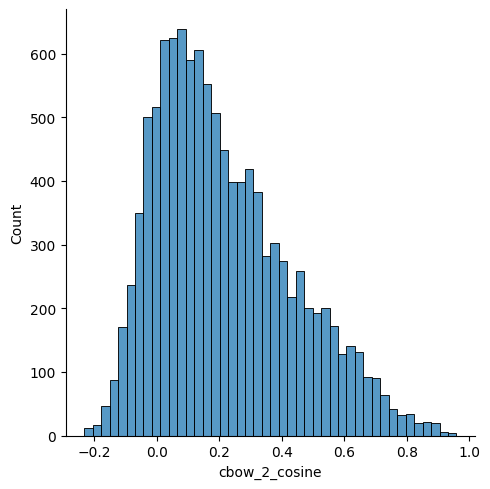

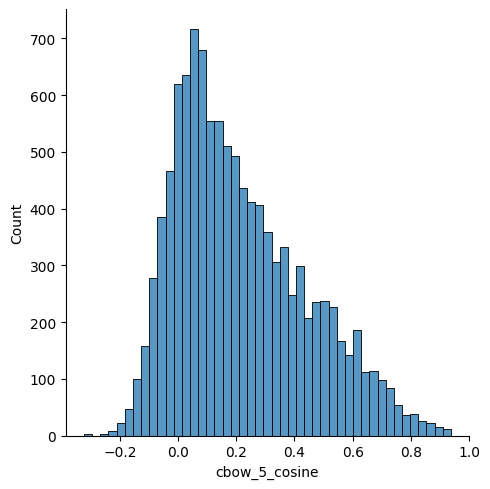

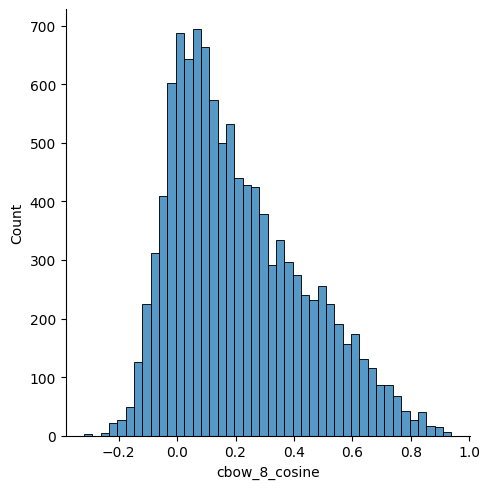

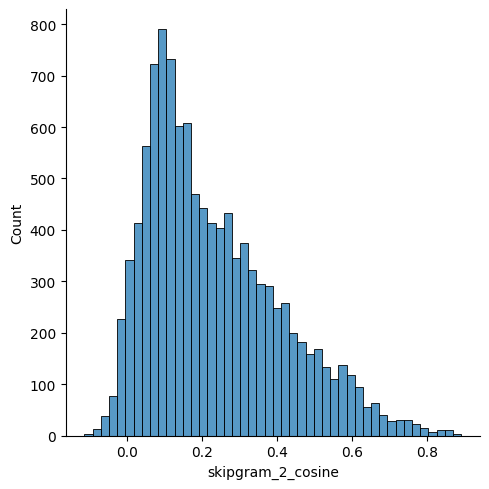

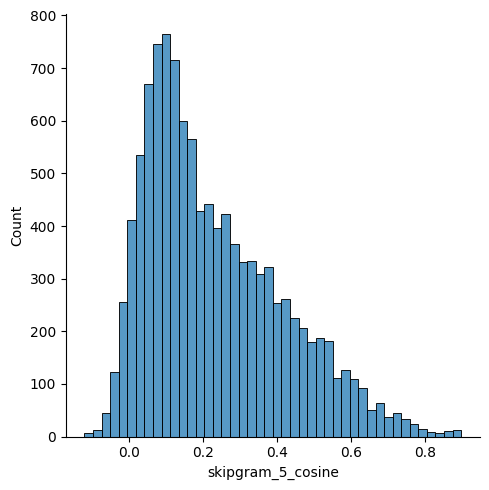

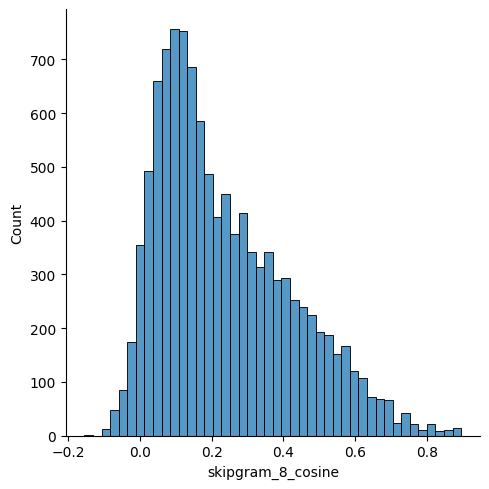

In [12]:
display(test_df)

for cosine_similarity_name in ["cbow_2_cosine", "cbow_5_cosine", "cbow_8_cosine", "skipgram_2_cosine", "skipgram_5_cosine", "skipgram_8_cosine"]:
    sns.displot(data=test_df, x=cosine_similarity_name)    